# BEAST - Tutorial on the Bayesian Extinction and Stellar Tool

Large parts of the text are copy-paste from the paper. The goal of this notebook is to (a) make simple unit tests to the code and (b) introduce the code functions through practical examples from the science POV.

In [1]:
# Loading configuration for the notebook. 
# BUG in osX el Capitan that limits to 256
# Remember to run before ipython.
# ulimit -n 4096

%pylab inline

# Mac retina and HiRes displays configuration
# make figures at 2x resolution on screen.
%config InlineBackend.figure_format='retina'

import pylab as plt
import numpy as np

# my configuration of mpl
import figrc, setup_mpl
setup_mpl.theme()

Populating the interactive namespace from numpy and matplotlib


We present the Bayesian Extinction And Stellar Tool (BEAST), a probabilistic approach to modeling
the dust extinguished photometric spectral energy distribution of an individual star while accounting
for observational uncertainties common to large resolved star surveys. 

Given a set of photometric measurements and an observational uncertainty model, the BEAST infers the physical properties of the stellar source using stellar evolution and atmosphere models and constrains the line of sight
extinction.

Below, we go through examples of using the different ingredients of BEAST. 
We first introduce stellar atmospheres that we then combine with stellar evolution models to generate a collection of dust free spectra. Then we show how to use the dust components before calculating passband SED predictions.

_All code below remains generic and should be easily adapted to any need._

## Stellar dust free spectra

The physics of a star’s intrinsic SED can be described by a combination of stellar atmosphere and stellar evolutionary models. The spectral energy distribution (SED), of a single star with birth mass $M_i$, age $t$,
and metallicity $Z$ is
$$L_\lambda(M_i, t, Z) = 4\pi\, [R(M_i, t, Z)]^2 \, S_\lambda(T_{eff}, \log(g), Z),$$
where $R(M_i, t, Z)$ is the star’s radius, given by stellar evolution models, and $S_\lambda(T_{eff}, \log(g), Z)$ is the star’s surface flux given by stellar atmosphere models and parameterized by the star’s effective temperature, $T_{eff}$, surface gravity, $\log(g)$, and metallicity $Z$ (the latter should be in principle a vector of abundances). 

### Stellar atmospheres & Spectral libraries

The basis to generate spectra is of course to use a spectral library or stellar atmosphere models. BEAST provides a simple interface to these into `beast.stellibs`. Additionally, BEAST can merge two or more stellar atmosphere grids transparently for the user.

Below we show the combination used in the paper, i.e., the local thermal equilibrium (LTE) CK04 grid (Castelli & Kurucz 2004) and non-LTE TLusty OSTAR and BSTAR grids (Lanz & Hubeny 2003, 2007).
We plot the HR diagrams of the individual spectral libraries , TLusty and Kurucz in blue and red, respectively. The dots indicate the actual models present in the library and the shaded region the default regions where extrapolation may be allowed. A significant overlap exists between the 2 libraries.

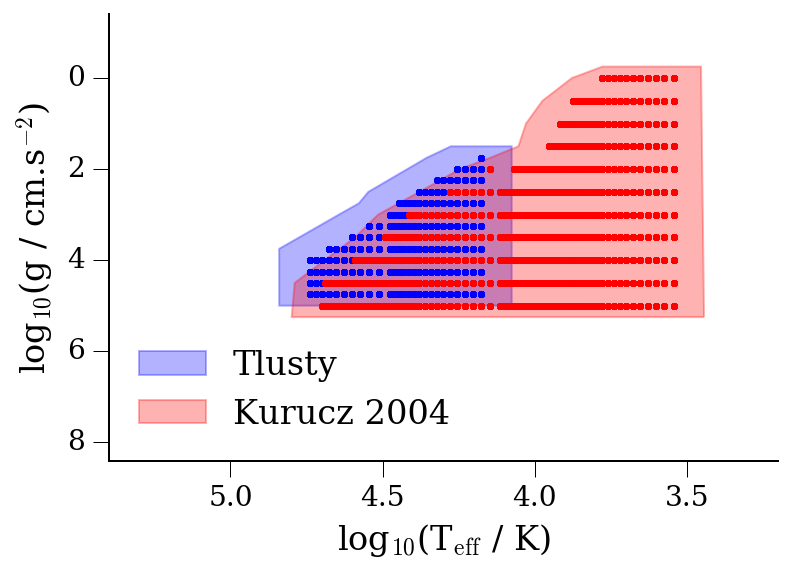

In [2]:
from beast.stellibs import Tlusty
from beast.stellibs import Kurucz

s = Tlusty()
s1 = Kurucz()
dlogT = 0.1
dlogg = 0.25
s.plot_boundary(alpha=0.3, color='b', dlogT=dlogT, dlogg=dlogg, label=s.name)
s1.plot_boundary(alpha=0.3, color='r', dlogT=dlogT, dlogg=dlogg, label=s1.name)
plt.plot(s.grid.logT, s.grid.logg, 'b.')
plt.plot(s1.grid.logT, s1.grid.logg, 'r.')

plt.legend(frameon=False, loc='best')
plt.xlim(5.4, 3.2)
plt.ylim(8.4, -1.4)
plt.xlabel('log$_{10}$(T$_{\\rm{eff}}$ / K)')
plt.ylabel('log$_{10}$(g / cm.s$^{-2}$)')
figrc.hide_axis('top right'.split())

### Combining different libraries

The merging for PHAT was done by preferring the TLusty non-LTE models over the CK04 LTE models in regions of overlap, given the higher fidelity of the non-LTE modeling for hot stars although the spectra of stars in the overlap regions are very similar (Lanz & Hubeny 2003).

To generate the combined library, one only need to use the `Operator +` and start the definition by order of priority. Below a snippet that combines the two mentioned libraries with priority on Tlusty:
```python
from beast import stellibs
lib = stellibs.Tlusty() + stellibs.Kurucz()
```

Below we plot the same figure as before using the combined library. The methods and functions are identical to using a single set of models.

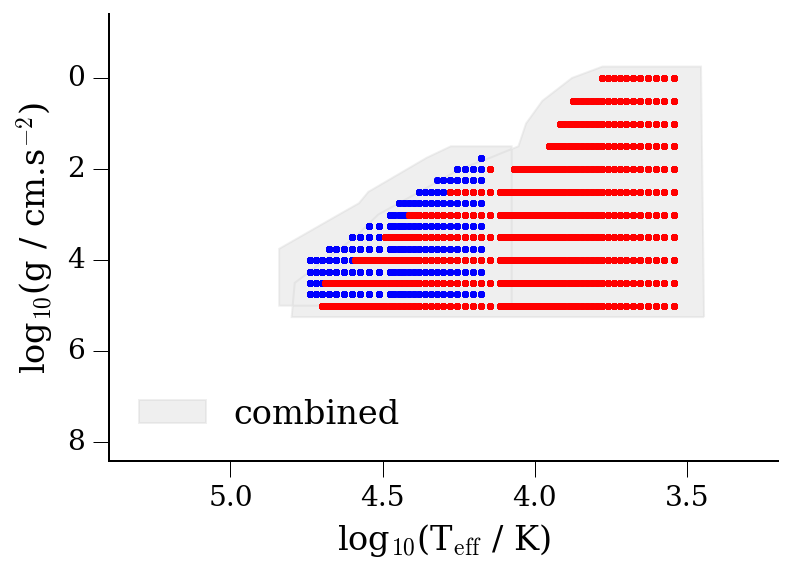

In [3]:
from beast.stellibs.tlusty import Tlusty
from beast.stellibs.kurucz import Kurucz

s = Tlusty()
s1 = Kurucz()
dlogT = 0.1
dlogg = 0.25
(s + s1).plot_boundary(alpha=0.3, color='0.8', dlogT=dlogT, dlogg=dlogg, label="combined")
plt.plot(s.grid.logT, s.grid.logg, 'b.')
plt.plot(s1.grid.logT, s1.grid.logg, 'r.')

plt.legend(frameon=False, loc='best')
plt.xlim(5.4, 3.2)
plt.ylim(8.4, -1.4)
plt.xlabel('log$_{10}$(T$_{\\rm{eff}}$ / K)')
plt.ylabel('log$_{10}$(g / cm.s$^{-2}$)')
figrc.hide_axis('top right'.split())

### Other libraries

We made the BEAST flexible and therefore we also provide other common libraries. Below we present the same example as before but instead combining the BaSeL and Rauch libraries. BaSeL is basically a Kurucz grid empirically re-calibrated and expanding its coverage towards cooler stars (eg. AGBs). Rauch is a library of white dwarf atmospheres.

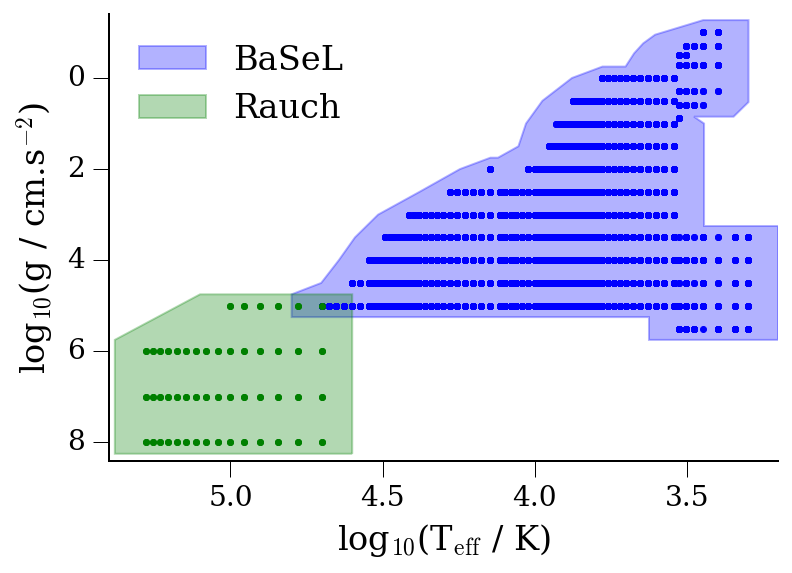

In [4]:
from beast import stellibs

basel = stellibs.BaSeL()
rauch = stellibs.Rauch()

dlogT = 0.1
dlogg = 0.25
basel.plot_boundary(alpha=0.3, color='b', dlogT=dlogT, dlogg=dlogg, label='BaSeL')
rauch.plot_boundary(alpha=0.3, color='g', dlogT=dlogT, dlogg=dlogg, label='Rauch')

plt.plot(basel.grid.logT, basel.grid.logg, 'b.')
plt.plot(rauch.grid.logT, rauch.grid.logg, 'g.')

plt.legend(frameon=False, loc='best')
plt.xlim(5.4, 3.2)
plt.ylim(8.4, -1.4)
plt.xlabel('log$_{10}$(T$_{\\rm{eff}}$ / K)')
plt.ylabel('log$_{10}$(g / cm.s$^{-2}$)')
figrc.hide_axis('top right'.split())

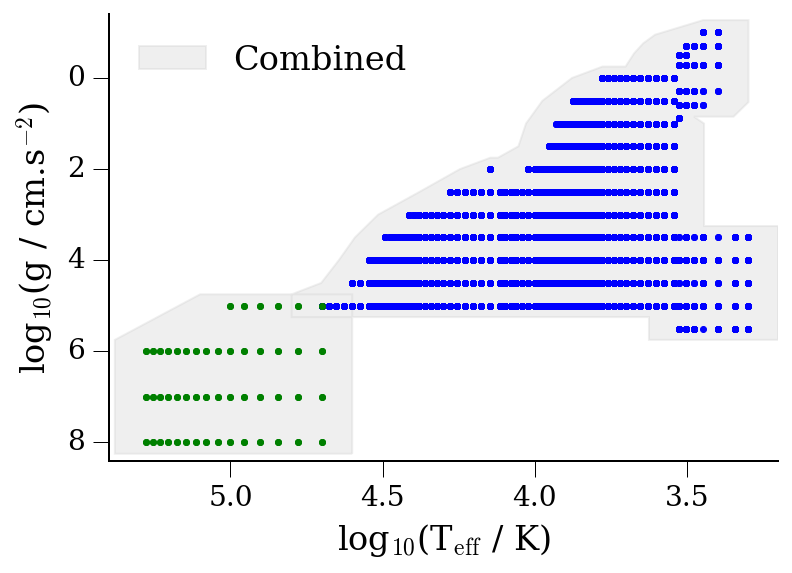

In [5]:
s = stellibs.Rauch() + stellibs.BaSeL()
dlogT = 0.1
dlogg = 0.25
s.plot_boundary(alpha=0.3, color='0.8', dlogT=dlogT, dlogg=dlogg, label='Combined')
plt.plot(basel.grid.logT, basel.grid.logg, 'b.')
plt.plot(rauch.grid.logT, rauch.grid.logg, 'g.')
plt.legend(frameon=False, loc='best')
plt.xlim(5.4, 3.2)
plt.ylim(8.4, -1.4)
plt.xlabel('log$_{10}$(T$_{\\rm{eff}}$ / K)')
plt.ylabel('log$_{10}$(g / cm.s$^{-2}$)')
figrc.hide_axis('top right'.split())

### Stellar evolution models

Stellar evolution models provide a mapping of $(M_i, t, Z)$ to $(T_{eff}, \log(g), Z)$, effectively reducing the number of free parameters needed to fully describe a star’s SED. We have selected $(M_, t, Z)$ as the fundamental stellar parameters because there is a direct mapping given by the stellar evolution models between
$(M_i, t, Z)$ and $(T_{eff}, \log(g), Z)$, whereas the reverse has degeneracies.


BEAST provides _currently_ a direct proxy to isochrone webservices through its `beast.stellarevol.isochrones` package. Further developments will provide access to stellar tracks directly (`beast.stellarevol.tracks`).

Below, we download a standard set of isochrones from the MESA/MIST library. Note that BEAST handles units when provided, but it will warn the user if units are assumed (and which assumptions are made).

In [6]:
from beast.stellarevol import isochrones
from beast.tools.ezunits import unit
age = 10 * unit['Myr']
metal = 0.02 # solar
t = isochrones.ezmist.get_standard_isochrone()

Interrogating http://waps.cfa.harvard.edu/MIST/iso_form.php...
Request...done.
Reading content...done.
decompressing archive (type=zip)...done.


`t` is a table that contains all the fields provided by MESA (see `beast.io.simpletable.SimpleTable` for reference).
Below we plot the temperature-luminosity diagram as a density map. The colors indicate the `log(count + 1)` values.

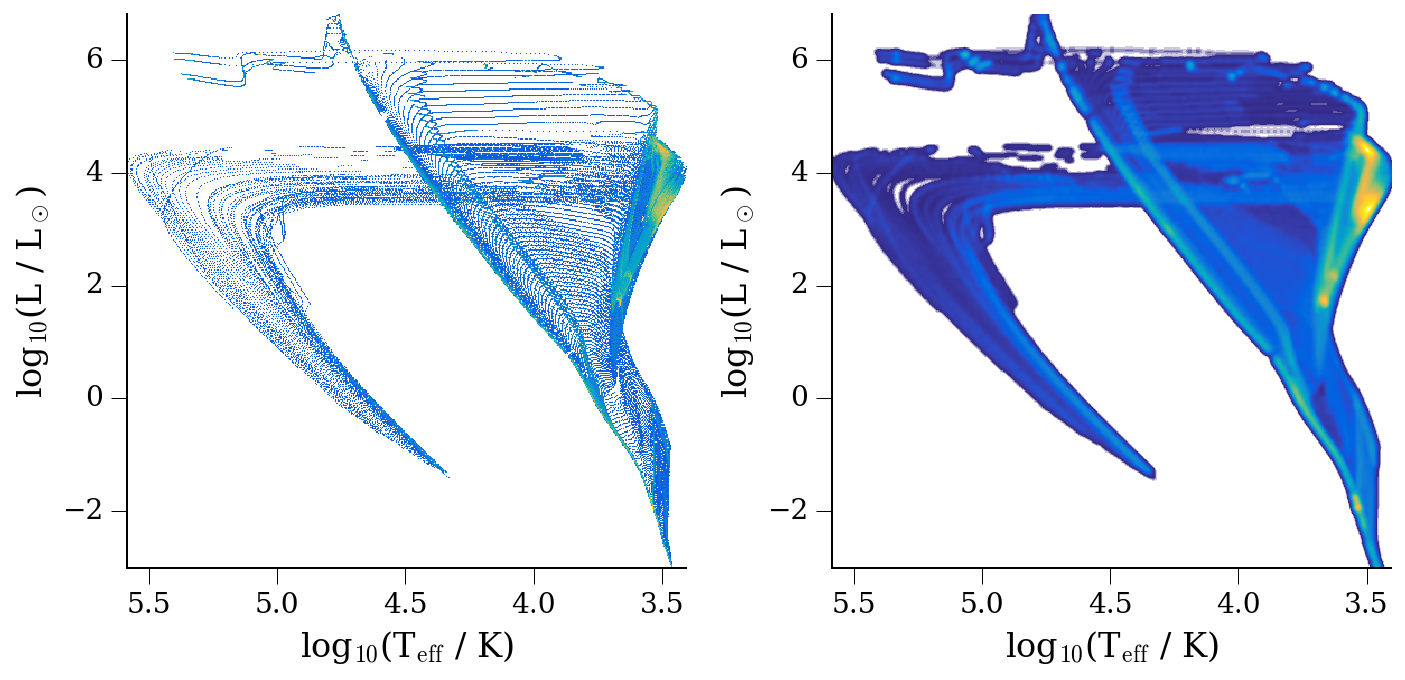

In [7]:
from beast.tools.density import plot_density

plt.figure(figsize=(10,5))
plt.subplot(121)
plot_density(t.logT, t.logL, bins=500, scaling='log(n+1)', cmap=plt.cm.parulaW)
plt.xlabel('log$_{10}$(T$_{\\rm{eff}}$ / K)')
plt.ylabel('log$_{10}$(L / L$_\odot$)')
plt.xlim(plt.xlim()[::-1])
figrc.hide_axis('top right'.split())

plt.subplot(122)
plot_density(t.logT, t.logL, bins=500, scaling='log(n+1)', cmap=plt.cm.parulaW, smooth=2)
plt.xlabel('log$_{10}$(T$_{\\rm{eff}}$ / K)')
plt.ylabel('log$_{10}$(L / L$_\odot$)')
plt.xlim(plt.xlim()[::-1]) 
figrc.hide_axis('top right'.split())
plt.tight_layout()

We do not argue the quality of one set of isochrones compared to others here.

### Interpolating spectral libraries

Once we have decided on a (combination of) library(ies) and a set of stellar parameters (e.g., isochrones or tracks), we need to generate the spectra of interest.

This procedure is easily done through the stellar library interpolation functions and in particular `Stellib.genIndividualStellarSpectrum` method. The example below computes the spectra associated to each individual point of the standard set of isochrones downloaded previously.

In [8]:
from beast.stellibs.tlusty import Tlusty
from beast.stellibs.kurucz import Kurucz

s = Kurucz() + Tlusty()
Z = 0.02   # solar metal
wave, specs = s.genIndividualStellarSpectrum(t, Z, with_units=False)

StellarSpectrum:|##########| 105313/105313 100% [time: 01:52, eta: 00:00, 936.71 iters/sec]


Below we plot a subsample of these newly calculated spectra.

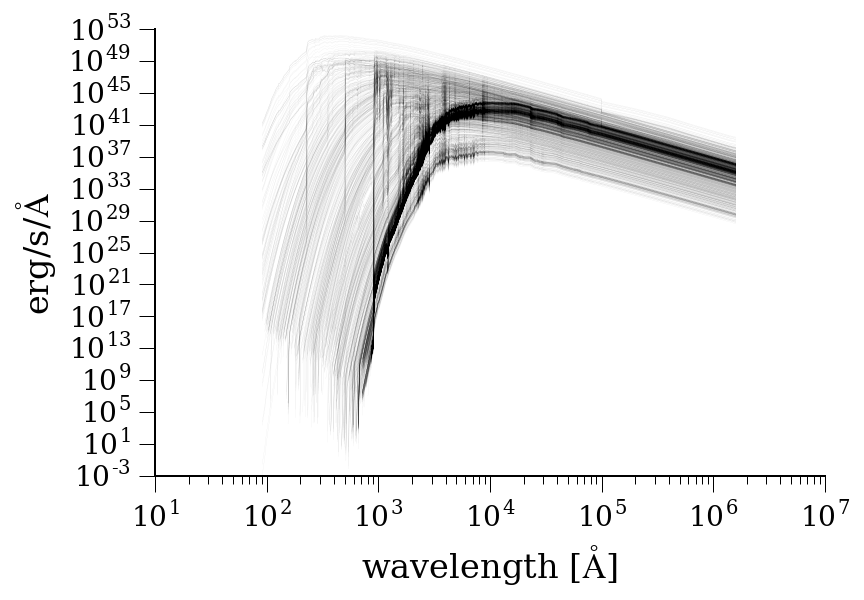

In [9]:
if (len(specs) <= 2000):
        plt.loglog(wave, specs.T, color='k', alpha=0.1, lw=0.1)
else:
    ind = np.random.randint(0, len(specs)-1, 2000)
    plt.loglog(wave, specs[ind].T, color='k', alpha=0.1, lw=0.1)
plt.xlabel(r'wavelength [${\rm\AA}$]')
plt.ylabel(r'erg/s/$\rm\AA$')
figrc.hide_axis('top right'.split())

## Extinction and dust modeling

The physical model used in the BEAST provides predictions of the SED of a single star extinguished by dust.
Interstellar dust extinguishes stellar light as it travels from the star’s surface to the observer. The wavelength dependence of the extinction from the UV to the NIR has been measured along many sightlines in the Milky Way
(Cardelli et al. 1989; Fitzpatrick 1999; Valencic et al. 2004; Gordon et al. 2009) and for a handful of sightlines in the Magellanic Clouds (Gordon & Clayton 1998; Misselt et al. 1999; Maız Apellaniz & Rubio 2012) as well
as in M31 (Bianchi et al. 1996, Clayton et al. 2015, submitted).

The observations show a wide range of dust column normalized extinction curves, $A(\lambda) / A(V)$. BEAST provides a set of commonly used extinction laws in the `beast.extinction` package.

In [2]:
from beast import extinction
from beast.tools.ezunits import unit

Below we have a look at the usual extinction functions. Note the use of units which simplifies the use of these methods.

In [3]:
#define the wave numbers
x = np.arange(0.1, 10, 0.1)   # in um^-1
lamb = (1e4 / x) * unit['angstrom']

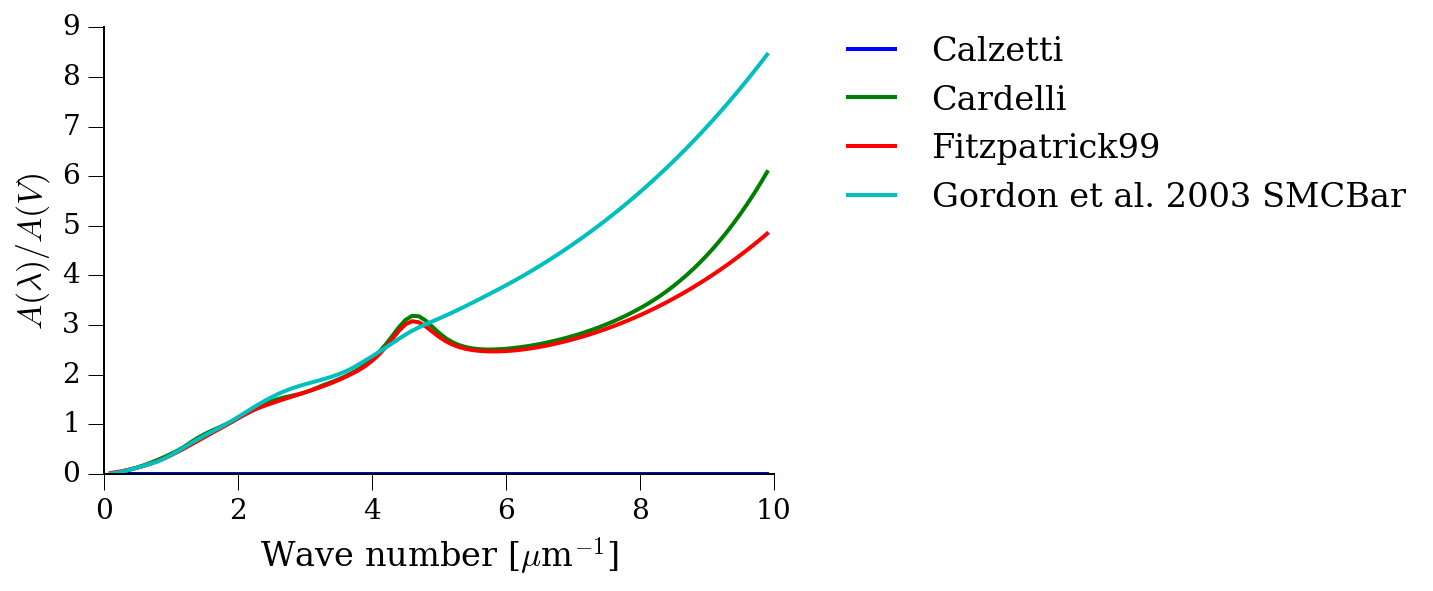

In [4]:
# list of law to test
laws = (extinction.Calzetti(),
        extinction.Cardelli(),
        extinction.Fitzpatrick99(), 
        extinction.Gordon03_SMCBar(),
       )

Rv = 3.1
for l in laws:
    plt.plot(x, l(lamb, Rv=Rv), label=l.name, lw=2)
plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1.05, 1.05) )
plt.xlabel(r'Wave number [$\mu$m$^{-1}$]')
plt.ylabel(r'$A(\lambda) / A(V)$')
figrc.hide_axis('top right'.split())

Effect of Rv on Fitzpatrick extinction law

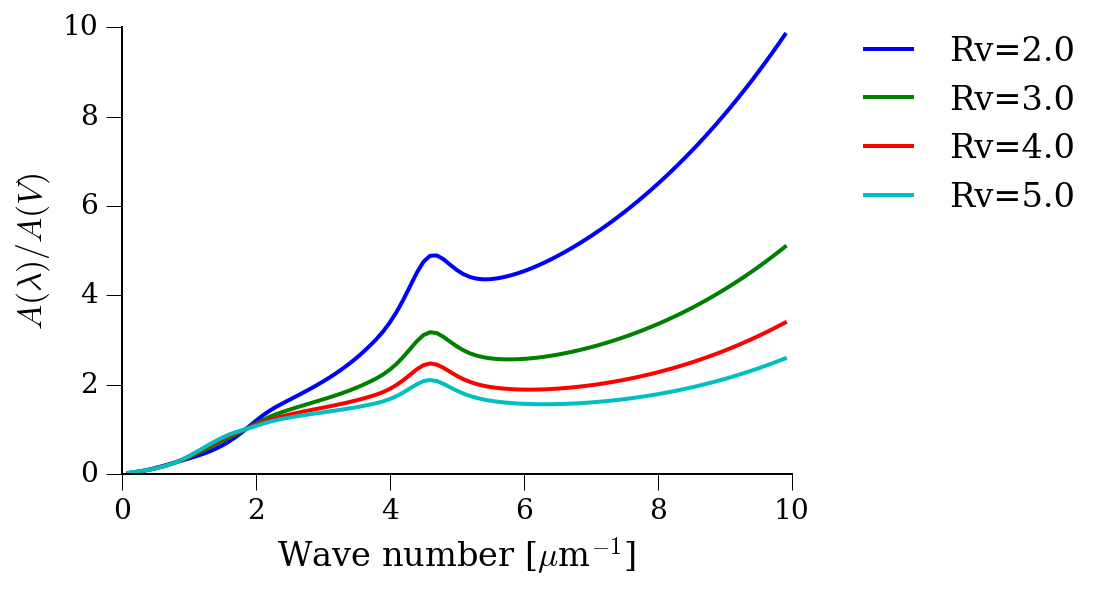

In [5]:
Rv_vals = np.arange(2, 6, dtype=float)
l = extinction.Fitzpatrick99()

for Rv in Rv_vals:
    plt.plot(x, l(lamb, Rv=Rv), label='Rv={0:0.1f}'.format(Rv), lw=2)
plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1.05, 1.05) )
plt.xlabel(r'Wave number [$\mu$m$^{-1}$]')
plt.ylabel(r'$A(\lambda) / A(V)$')
figrc.hide_axis('top right'.split())

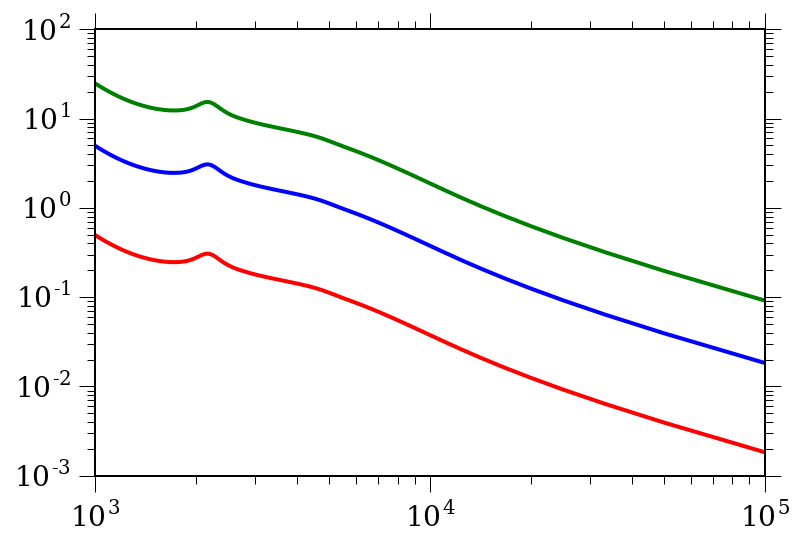

In [18]:
l = extinction.Fitzpatrick99()
#define the wave numbers
x = np.arange(0.1, 10, 0.1)   # in um^-1
lamb = (1e4 / x) * unit['angstrom']

plt.semilogx(lamb.magnitude, l(lamb, Av=1.), lw=2)
plt.semilogx(lamb.magnitude, l(lamb, Av=5.), lw=2)
plt.loglog(lamb.magnitude, l(lamb, Av=0.1), lw=2)

### Mixing different laws.

we introduce a mixture model with two components $A$ and $B$ to describe the full range of observed extinction curves in the Local Group.

When $f_A$ gives the fraction of the $A$-type extinction and $(1 − f_A)$ the fraction of the $B$-type extinction, this mixture is defined as follow:
$$ \frac{A(\lambda)}{A(V)} = f_A\,\left[\frac{A(\lambda)}{A(V)}\right]_A + (1 - f_A)\,\left[\frac{A(\lambda)}{A(V)}\right]_B,$$

The effective $R(V)$ of the mixture extinction curve model is then given by:
$$ R(V)^{-1} = f_A\,R_A(V)^{-1} + (1 - f_A)\,R_B(V)^{-1}.$$

Beast code is made flexible enough that any laws can be combined. 

Below we use `Fitzpatrick` (A) definition with the `SMCBar` (B) with fix $R_B(V) = 2.74$ (Gordon et al. 2003), as we did for PHAT. 
The range of observed $R_A(V)$ is between 2.0 and 6.0 and this results in the parameter space defined by $(R(V), f_A)$ not being completely filled.

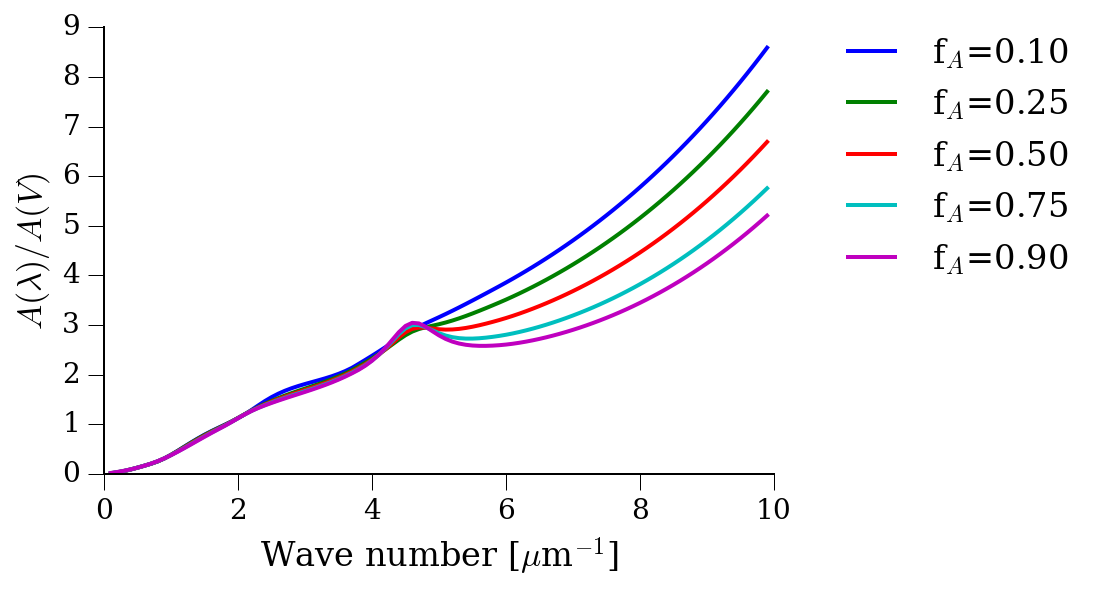

In [14]:
mixture = extinction.Fitzpatrick99() + extinction.Gordon03_SMCBar()
Rv = 3.1
f_A_vals = (0.1, 0.25, 0.5, 0.75, 0.9)

for f_A in f_A_vals:
    plt.plot(x, mixture(lamb, Rv=Rv, f_A=f_A), label=r'f$_A$={0:0.2f}'.format(f_A), lw=2)
plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1.05, 1.05) )
plt.xlabel(r'Wave number [$\mu$m$^{-1}$]')
plt.ylabel(r'$A(\lambda) / A(V)$')
figrc.hide_axis('top right'.split())

Once calculated for a given set of parameters, interstellar extinction $A(\lambda) / A(V)$ is included as a multiplicative term:
$$D_\lambda(A(V), R(V), f_A) = 10^{-0.4 A(V)\times A(\lambda) / A(V)}$$

## Photometry

Using the two previous sections, one can produce a collection of dust attenuated spectra.
For a star at a distance $d$, we write the full model for the monochromatic flux:
$$ F_\lambda(M_i, t, Z, A(V), R(V), f_A, d) = \frac{1}{4 \pi d^2} \, L_\lambda (M_i, t, Z) \, D_\lambda(A(V), R(V), f_A)$$

To compare with photometric observations, we need to compute model fluxes in the same bands as the observations.
We calculate the model band flux in bandpass $i$ as
$$ F_i = \frac{\int \lambda B_i(\lambda) F_\lambda d\lambda}{\int \lambda B_i(\lambda) d\lambda},$$

where $B_i(\lambda)$ is the bandpass response function for the
$i$-th band in fractional photon units. This integration is
done in photon units.

BEAST provides a large collection of passbands and easy method to define new ones. All photometric related functions are given in `beast.photometry`.

Below we show an example usage of the passband filter library.

In [15]:
from beast.photometry import phot

In [16]:
content = phot.get_library_content()
print(content[:10])
print("library contains {0:d} filters.".format(len(content)))

[b'GROUND_JOHNSON_U' b'GROUND_JOHNSON_B' b'GROUND_JOHNSON_V'
 b'GROUND_COUSINS_R' b'GROUND_COUSINS_I' b'GROUND_BESSELL_J'
 b'GROUND_BESSELL_H' b'GROUND_BESSELL_K' b'HST_NIC2_F110W'
 b'HST_NIC2_F160W']
library contains 192 filters.


In [17]:
print(content)

[b'GROUND_JOHNSON_U' b'GROUND_JOHNSON_B' b'GROUND_JOHNSON_V'
 b'GROUND_COUSINS_R' b'GROUND_COUSINS_I' b'GROUND_BESSELL_J'
 b'GROUND_BESSELL_H' b'GROUND_BESSELL_K' b'HST_NIC2_F110W'
 b'HST_NIC2_F160W' b'HST_NIC2_F205W' b'HST_WFPC2_F218W'
 b'HST_ACS_HRC_F220W' b'HST_ACS_HRC_F250W' b'HST_WFPC2_F255W'
 b'HST_WFPC2_F300W' b'HST_ACS_HRC_F330W' b'HST_WFPC2_F336W'
 b'HST_ACS_HRC_F344N' b'HST_ACS_HRC_F435W' b'HST_ACS_WFC_F435W'
 b'HST_WFPC2_F439W' b'HST_WFPC2_F450W' b'HST_ACS_HRC_F475W'
 b'HST_ACS_WFC_F475W' b'HST_ACS_HRC_F502N' b'HST_ACS_WFC_F502N'
 b'HST_ACS_HRC_F550M' b'HST_ACS_WFC_F550M' b'HST_ACS_HRC_F555W'
 b'HST_ACS_WFC_F555W' b'HST_WFPC2_F555W' b'HST_ACS_HRC_F606W'
 b'HST_ACS_WFC_F606W' b'HST_WFPC2_F606W' b'HST_WFPC2_F622W'
 b'HST_ACS_HRC_F625W' b'HST_ACS_WFC_F625W' b'HST_ACS_HRC_F658N'
 b'HST_ACS_WFC_F658N' b'HST_ACS_HRC_F660N' b'HST_ACS_WFC_F660N'
 b'HST_WFPC2_F675W' b'HST_ACS_HRC_F775W' b'HST_ACS_WFC_F775W'
 b'HST_WFPC2_F791W' b'HST_ACS_HRC_F814W' b'HST_ACS_WFC_F814W'
 b'HST_WFPC2_F8

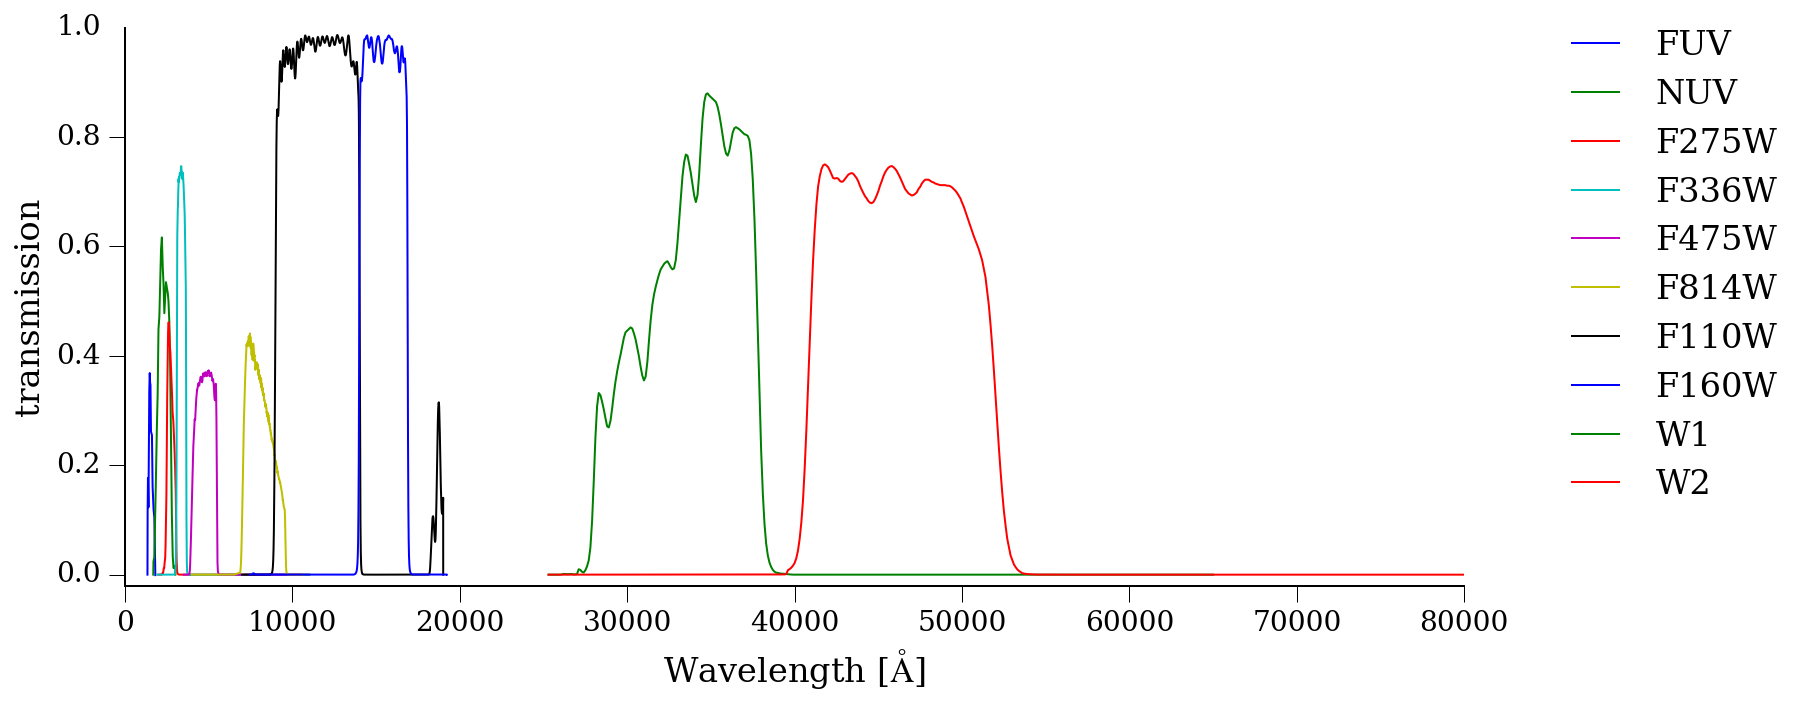

In [18]:
filter_names = 'galex_fuv galex_nuv hst_wfc3_f275w hst_wfc3_f336w hst_acs_wfc_f475w hst_acs_wfc_f814w hst_wfc3_f110w hst_wfc3_f160w wise_rsr_w1 wise_rsr_w2'.upper().split()
flist = phot.load_filters(filter_names)
flist[-1].wavelength *= 1e4
flist[-2].wavelength *= 1e4
plt.figure(figsize=(12,5))
for f in flist:
    plt.plot(f.wavelength, f.transmit, lw=1, label=f.name.split('_')[-1])
plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1.05, 1.05) )
plt.xlabel(r'Wavelength [$\rm{\AA}$]')
plt.ylabel(r'transmission')
plt.ylim(-0.02, 1)
#plt.yscale('log')
#plt.ylim(1e-7, 1)
figrc.hide_axis('top right'.split())

Once we define a set of filters, we can compute the integrated flux of spectra through these. The example below computes the SEDs of the spectra calculated before and plot a subset of them.

In [19]:
filter_names = 'hst_wfc3_f275w hst_wfc3_f336w hst_acs_wfc_f475w hst_acs_wfc_f814w hst_wfc3_f110w hst_wfc3_f160w'.upper().split()
flist = phot.load_filters(filter_names, lamb=wave)
central_wave, seds = phot.extractSEDs(wave, specs, flist)

In [20]:
filter_names = 'galex_fuv galex_nuv hst_wfc3_f275w hst_wfc3_f336w hst_acs_wfc_f475w hst_acs_wfc_f814w hst_wfc3_f110w hst_wfc3_f160w wise_rsr_w1 wise_rsr_w2'.upper().split()
filter_names = ('galex_fuv galex_nuv'.upper().split()
                + 'GROUND_SDSS_G GROUND_2MASS_J GROUND_2MASS_H GROUND_2MASS_Ks'.split()
                + 'wise_rsr_w1 wise_rsr_w2'.upper().split())
f1 = phot.load_filters(filter_names[:-2], lamb=wave)
f2 = phot.load_filters(filter_names[-2:])
fwise = [phot.Filter(wave, np.interp(wave, fk.wavelength * 1e4, fk.transmit), name=fk.name) for fk in f2]
flist = f1 + fwise

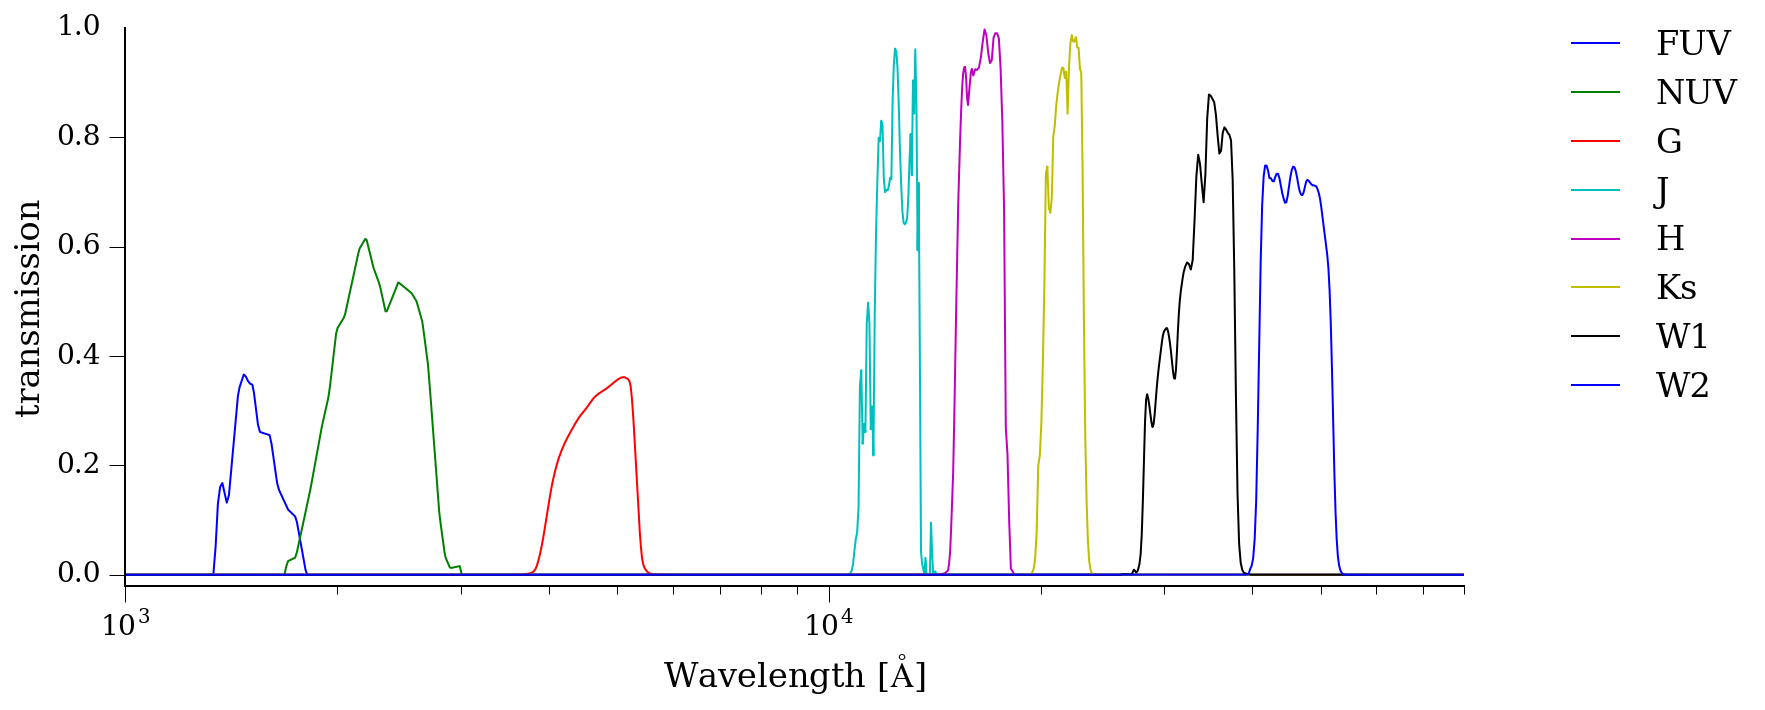

In [21]:
plt.figure(figsize=(12,5))
for f in flist:
    plt.plot(f.wavelength, f.transmit, lw=1, label=f.name.split('_')[-1])
plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1.05, 1.05) )
plt.xlabel(r'Wavelength [$\rm{\AA}$]')
plt.ylabel(r'transmission')
plt.ylim(-0.02, 1)
plt.xlim(1e3, 80000)
plt.xscale('log')
#plt.yscale('log')
#plt.ylim(1e-7, 1)
figrc.hide_axis('top right'.split())

In [22]:
central_wave, seds = phot.extractSEDs(wave, specs, flist)

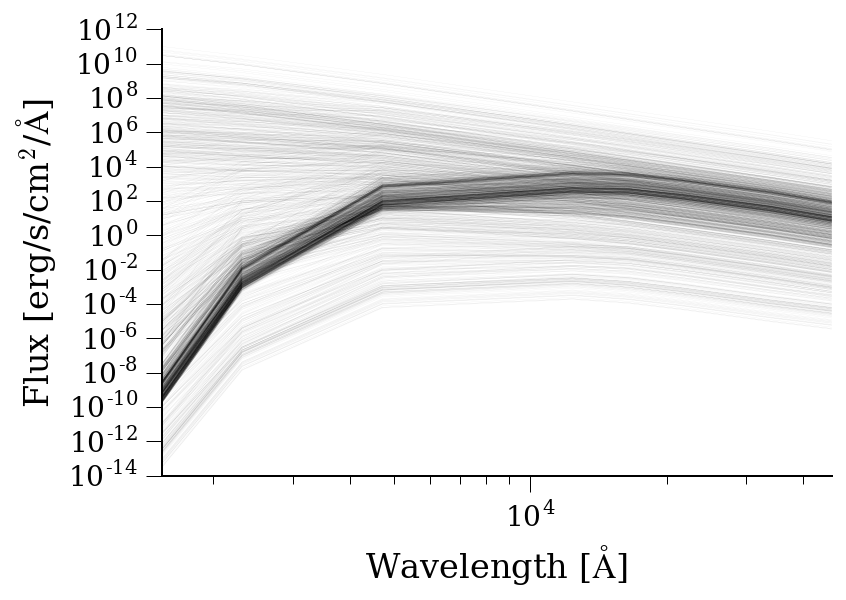

In [23]:
if (len(specs) <= 2000):
        plt.loglog(wave, seds.T, color='k', alpha=0.1, lw=0.1)
else:
    ind = np.random.randint(0, len(seds)-1, 2000)
    plt.loglog(central_wave, seds[ind].T, color='k', alpha=0.1, lw=0.1)
plt.xlim(central_wave.min(), central_wave.max())
plt.xlabel(r'Wavelength [$\rm{\AA}$]')
plt.ylabel(r'Flux [erg/s/cm$^2$/$\rm\AA$]')
figrc.hide_axis('top right'.split())

One could compare the spectra with integrated SED values. Note that the filters we selected have non-trivial tails. Sometimes the photometry is not what expected just based on the filter central wavelength.

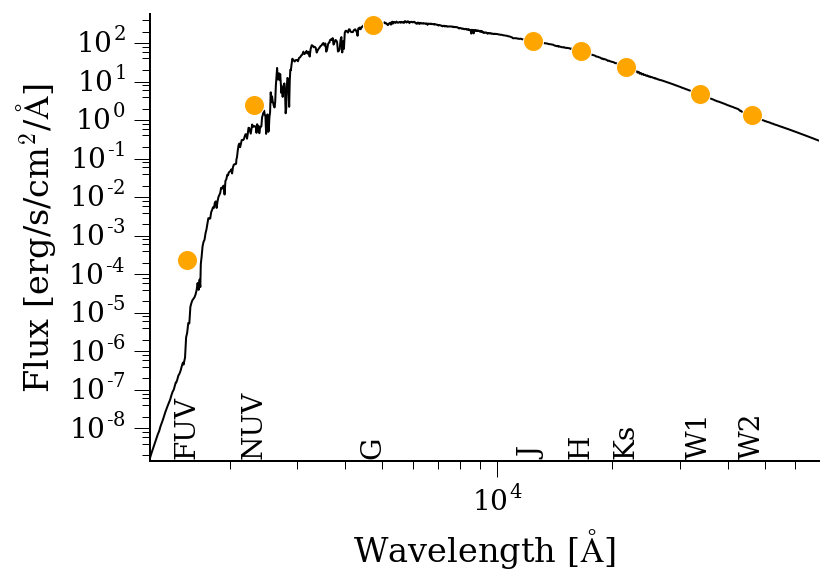

In [24]:
select = 100
_spec = specs[select] / phot.distc
plt.loglog(wave, _spec, 'k-')
plt.loglog(central_wave, seds[select], 'o', ms=10, mec='w', mfc='orange')
plt.xlabel(r'Wavelength [$\rm{\AA}$]')
plt.ylabel(r'Flux [erg/s/cm$^2$/$\rm\AA$]')
plt.xlim(0.8 * central_wave.min(), 1.5 * central_wave.max())
ind = (wave >= 0.8 * central_wave.min()) & (wave <= 1.5 * central_wave.max())
plt.ylim(0.85 * _spec[ind].min(), 1.5 * _spec[ind].max())
for cl, f in zip(central_wave, flist):
    plt.text(cl, 0.95 * _spec[ind].min(), f.name.split('_')[-1], rotation=90, ha='center', va='bottom')
figrc.hide_axis('top right'.split())

### Using Vega magnitudes

In [25]:
from beast.photometry.vega import Vega

with Vega() as v:
    vega_zpts = v.getMag(flist)

for fk, val in zip(flist, vega_zpts):
    print("{0:15s}".format(fk.name), val)

GALEX_FUV       20.4660253138
GALEX_NUV       20.8780665631
GROUND_SDSS_G   20.6630941778
GROUND_2MASS_J  23.7660894508
GROUND_2MASS_H  24.8610774841
GROUND_2MASS_Ks 25.9214001282
WISE_RSR_W1     27.711401706
WISE_RSR_W2     29.0355022327


## Making a collection of models

Once you have a collection of dust free spectra, you can apply the dust easily. The rest is book keeping.

See `collect.py`

## Likelihood

## Predicting Bolometric luminosities

In [ ]:
from beast.fitting import learn
from sklearn.ensemble import ExtraTreesRegressor

bol = learn.GenericPredictor(ExtraTreesRegressor, fn_kwargs=dict(n_estimators=50, bootstrap=True), degree=1)
y = specs.sum(1)
# cleaning bad interpolation & pre-MS
ind = np.all(np.isfinite(seds), axis=1) & (y > 0) & np.isfinite(y) & (t.phase >=0) 
X = seds[ind]
y = -2.5 * np.log10(y[ind] / phot.distc )
bol.fit(X, y)

In [ ]:
ypred = np.squeeze(bol.predict(X))
print(ypred.shape)

In [ ]:
plot_density(y, ypred-y, cmap=plt.cm.parulaW, range=((y.min(), y.max()), (-2, 2)), bins=400, smooth=3)
plt.xlabel('True M$_{bol}$')
plt.ylabel('$\Delta$ M$_{bol}$')
figrc.hide_axis('top right'.split())

In [ ]:
plot_density(t.logT[ind], ypred-y, cmap=plt.cm.parulaW, range=((3.2, 5), (-2, 2)), bins=400, smooth=3)
plt.xlabel('True T$_{eff}$')
plt.ylabel('$\Delta$ M$_{bol}$')
figrc.hide_axis('top right'.split())

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plot_density(t.logT[ind], t.logL[ind], bins=400, smooth=3, scaling='log(n+1)', cmap=plt.cm.parulaW)
plt.xlabel('log$_{10}$(T$_{\\rm{eff}}$ / K)')
plt.ylabel('log$_{10}$(L / L$_\odot$)')
plt.xlim(plt.xlim()[::-1])
figrc.hide_axis('top right'.split())

plt.subplot(122)
plot_density(t.logT[ind], t.logL[ind], weights=ypred-y, bins=200, 
             scaling='count', cmap=plt.cm.RdBu, smooth=1, vmin=-0.1, vmax=0.1)
plt.colorbar().set_label('$\Delta$ M$_{bol}$')
plt.xlabel('log$_{10}$(T$_{\\rm{eff}}$ / K)')
#plt.ylabel('log$_{10}$(L / L$_\odot$)')
plt.xlim(plt.xlim()[::-1])
figrc.hide_axis('top right'.split())
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10,5))
ax = plt.subplot(121)
plot_density(t.logT[ind], t.logL[ind], bins=500, smooth=1, scaling='log(n+1)', cmap=plt.cm.parulaW)
plt.xlabel('log$_{10}$(T$_{\\rm{eff}}$ / K)')
plt.ylabel('log$_{10}$(L / L$_\odot$)')
plt.xlim(plt.xlim()[::-1])
figrc.hide_axis('top right'.split())

plt.subplot(122, sharex=ax, sharey=ax)
plot_density(t.logT[ind], t.logL[ind], weights=ypred-y, bins=500, 
             scaling='count', cmap=plt.cm.RdBu, smooth=1, vmin=-1, vmax=1.)
plt.colorbar().set_label('$\Delta$ M$_{bol}$')
plt.xlabel('log$_{10}$(T$_{\\rm{eff}}$ / K)')
#plt.ylabel('log$_{10}$(L / L$_\odot$)')
plt.xlim(plt.xlim()[::-1])
plt.xlim(3.9, 3.4)
plt.ylim(-2, 3)
figrc.hide_axis('top right'.split())
plt.tight_layout()

### What if distance error?

10% error in distance

In [ ]:
distance_error = 0.3
distances = np.random.normal(10, distance_error, len(X))
Xnoise = X[:] / ((distances[:, None] / 10 ) ** 2 )

In [ ]:
print((X - Xnoise).ptp())
ynoise = np.squeeze(bol.predict(Xnoise))

In [ ]:
plt.figure(figsize=(10, 5))
ax = plt.subplot(121)
plot_density(y, ypred - y, bins=400, smooth=2, cmap=plt.cm.parulaW, range=((y.min(), y.max()), (-2, 2)))
plt.text(0.1, 0.1, "perfect distance", transform=ax.transAxes)
plt.xlabel('True M$_{bol}$')
plt.ylabel('$\Delta$ M$_{bol}$')
figrc.hide_axis('top right'.split())
ax = plt.subplot(122, sharex=ax, sharey=ax)
plot_density(y, ynoise - y, bins=400, smooth=2, cmap=plt.cm.parulaW, range=((y.min(), y.max()), (-2, 2)))
plt.text(0.1, 0.1, "{0:0.1g} distance error".format(distance_error), transform=ax.transAxes)
plt.ylim(-2,2)
plt.xlabel('True M$_{bol}$')
figrc.hide_axis('top right'.split())
plt.tight_layout()

In [ ]:
plt.figure(figsize=(10,5))
ax = plt.subplot(121)
plot_density(t.logT[ind], t.logL[ind], bins=500, smooth=1, scaling='log(n+1)', cmap=plt.cm.parulaW)
plt.xlabel('log$_{10}$(T$_{\\rm{eff}}$ / K)')
plt.ylabel('log$_{10}$(L / L$_\odot$)')
plt.xlim(plt.xlim()[::-1])
figrc.hide_axis('top right'.split())

plt.subplot(122, sharex=ax, sharey=ax)
plot_density(t.logT[ind], t.logL[ind], weights=ynoise-y, bins=500, 
             scaling='count', cmap=plt.cm.RdBu, smooth=1, vmin=-0.1, vmax=0.1)
plt.colorbar().set_label('$\Delta$ M$_{bol}$')
plt.xlabel('log$_{10}$(T$_{\\rm{eff}}$ / K)')
#plt.ylabel('log$_{10}$(L / L$_\odot$)')
plt.xlim(plt.xlim()[::-1])
plt.xlim(3.9, 3.4)
plt.ylim(-2, 3)
figrc.hide_axis('top right'.split())
plt.tight_layout()

### For the fun: equations....

In [ ]:
def show_equation(self, dim=0, lbls=None, **kwargs):
        """ Display the equation associated with the model

        Parameters
        ----------
        dim: int
            dimension of the label space to plot (default, 0)

        **kwargs goes to `plt.imshow`
        """
        if lbls is None:
            lbls = self.pars_names
        if lbls is None:
            lbls = ['p{0:d}'.format(k) for k in range(self.ndim)]
        lbls = learn.clean_names(learn.labels_polyfeatures_transformation(self._pf, lbls))

        im = self.coeffs[:][dim]

        
        ind = [np.abs(im) > 0]
        im = im[ind]
        lbls = np.array(lbls)[ind]

        return ["${0:s}$ $\cdot$ {1:s}".format(figrc.latex_float(a), b) for a, b in zip(im, lbls)]
    
    
def disp_equation(datamodel, pred="T_{eff}", lbls=None):
    eqns = show_equation(datamodel, lbls=lbls)
    txt = r"""\begin{eqnarray}"""
    txt += pred
    txt += r""" \approx& """
    txt += eqns[0].split('\cdot')[0] + '\\\\ \n'
    for k in eqns[1:]:
        if k[1] == '-':
            txt += "& " + k + '\\nonumber \\\\ \n'
        else:
            txt += "& + " + k + '\\nonumber \\\\ \n'
    txt = txt[:-3]
    txt += """
    \end{eqnarray}
    """
    return txt.replace('$', ' ')

from IPython.display import display, Markdown

In [ ]:
from beast.fitting import learn
import imp
imp.reload(learn)
from sklearn.linear_model import LassoLarsCV

bol1 = learn.GenericPredictor(LassoLarsCV, fn_kwargs=dict(max_iter=1000, cv=5), degree=5)
y = specs.sum(1)
# cleaning bad interpolation & pre-MS
ind = np.all(np.isfinite(seds), axis=1) & (y > 0) & np.isfinite(y) & (t.phase >=0) 
X = -2.5 * np.log10(seds[ind])
y = -2.5 * np.log10(y[ind] / phot.distc )
bol1.fit(X, y)

In [ ]:
ypred = np.squeeze(bol1.predict(X))
print(ypred.shape)

In [ ]:
plot_density(y, ypred - y, bins=500, smooth=2, cmap=plt.cm.parulaW, range=((y.min(), y.max()), (-.5, .5)))
# plt.text(0.1, 0.1, "perfect distance", transform=ax.transAxes)
plt.xlabel('True M$_{bol}$')
plt.ylabel('$\Delta$ M$_{bol}$')
figrc.hide_axis('top right'.split())

In [ ]:
plt.hist(ypred - y, bins=500, log=True);
plt.xlabel('$\Delta$ M$_{bol}$')
figrc.hide_axis('top right'.split())
print("RMS = ", np.mean((ypred - y) ** 2) ** 0.5)

In [ ]:
bol1.pars_names = [f.name.split('_')[-1] for f in flist]
bol1.plot_feature_importance(non_zero_only=True)
figrc.hide_axis('top right'.split())

In [ ]:
disp_equation(bol1, lbls=filter_names, pred='M_{bol}')

## Make a grid of models

## Fitting 

In [ ]:
def lnlike_knn(theta, data, dataerr, models, knn, cache=None, bounds=None):
    """ Define a log-likelihood function that works on a grid and continuous distance dimension in parsecs.
    It finds nearest neighbors on the model grid and then N-linearly interpolate between grid points 
    to predict the model fluxes at 10pc.
    then we dim the prediction according to the distance parameters.
    
    TODO: add polynomial features & normalization
    TODO: see how to generalize with covar matrices
    
    Parameters
    ----------
    theta: tuple
        model parameters + distance (e.g., logT, logg, logA, ... , distance.)
    data: array, ndim=1, dtype=float
        observed sed
    dataerr: array, ndim=1, dtype=float
        independent stddev on data values
    models: array, ndim=2, dtype=float
        grid of models
    knn: KNeighborsRegressor
        knn model predictor
    cache: tuple, optional
        set to keep track of all calls and lnlike values
    bounds: tuple, len=len(theta)
        tuples of limits on theta dimensions.
        
    Return
    ------
    lnlike: float
        log-likelihood(data | theta, dataerr)
    """
    try:  # faster than if test.
        for v, b in zip(theta, bounds):
            if not (b[0] <= v <= b[1]):
                lnp = -np.inf
                if cache is not None:
                    cache.append((theta, lnp))
                return lnp
    except TypeError:
        # bounds not given
        pass
    try:
        pred_sed = np.squeeze(knn.predict(np.atleast_2d(theta[:-1])))
        distance = False
    except:
        pred_sed = np.squeeze(knn.predict(np.atleast_2d(theta)))
        distance = True
    
    if np.any(pred_sed <= 0):
        lnp = -np.inf
    else:
        ind = (data > 0) & (pred_sed > 0)
        # magnitudes
        # r = -2.5 * np.log10(pred_sed[ind]) + 5 * np.log10(theta[-1] / 10) + 2.5 * np.log10(data[ind])
        # flux
        if distance is False:
            r = pred_sed[ind] / (theta[-1] / 10) ** 2 - data[ind]
        else:
            r = pred_sed[ind] - data[ind]
        lnp = -0.5 * (np.dot(r, r)) - 0.5 * np.log(2 * np.pi * (dataerr + 1e-4) ** 2).sum()
    if not np.isfinite(lnp):
        lnp = -np.inf
    if cache is not None:
        cache.append((theta, lnp))
    return lnp


def minus_lnlike(*args, **kwargs):
    """ -1 * lnlike function for optimization """
    return -lnlike_knn(*args, **kwargs)


def fit_latinhypercube(lnlike, bounds, Nsamples=1e3, args=(), kwargs={}):
    """ Draw Nsamples and compute their likelihoods using Latin Hypercube Sampling.
        
    Latin Hypercube Sampling ensures that each parameter is uniformly
    sampled over its range.
    
    parameters
    ----------
    lnlike: callable
        log likelihood function
    bounds: tuple
        boundary values of each dimension
    Nsamples: int
        number of samples to draw
    args: tuple, optional
        additional arguments to lnlike
    kwargs: dict, optional
        additional keyword arguments to lnlike
    
    returns
    -------
    samples: ndarray, ndim=2, len=Nsamples
        samples in parameter space
    lnps: ndarray, ndim=1, dype=float
        lnlike values for each sample.
    """
    lhs_samples = density.init_population_lhs(int(Nsamples), len(bounds), bounds)
    lhs_lnps = np.array([lnlike_knn(t, *args, **kwargs) for t in lhs_samples])
    return lhs_samples, lhs_lnps

In [ ]:
def plot_samples(d1, d2, samples, bounds=None, **kwargs):
    xtrue = kwargs.pop('true', None)
    names = pars + ['distance', 'lnp']
    x, y = samples[:, d1], samples[:, d2]
    if bounds is None:
        b1, b2 = ((x.min(), x.max()), (y.min(), y.max()))
    else:
        if len(bounds) == len(samples[0]):
            b1, b2 = (bounds[d1], bounds[d2])
        else:
            b1, b2 = bounds
    defaults = dict(bins=200, smooth=1, 
                    scaling='log(n+1)', 
                    range=(b1, b2), 
                    cmap=plt.cm.parulaW)
    defaults.update(**kwargs)
    plot_density(x, y, **defaults)
    if xtrue is not None:
        if len(xtrue) == len(samples[0]):
            xtrue = xtrue[d1], xtrue[d2]
        plt.vlines([xtrue[0]], *plt.ylim(), color='r', hold=True)
        plt.hlines([xtrue[1]], *plt.xlim(), color='r', hold=True)
    figrc.hide_axis(['top', 'right'])
    plt.xlabel(names[d1])
    plt.ylabel(names[d2])
    
    
def plot_1d_samples(xpred, lnp=None, truth=None, names=None, prior=False):
    plt.figure(figsize=(10, 4))
    
    if lnp is not None:
        best = s[lnp.argmax()]
        w = exp(lnp-lnp.max())
    else:
        best = None
        w = np.ones(len(xpred))
        
    for e, k in enumerate(xpred.T, 1):
        plt.subplot(1, len(xpred[0]), e)
        if prior:
            n, bx = plt.histogram(k, bins=20, normed=True)
            plt.plot(0.5 * (bx[1:] + bx[:-1]), n / n.max(), color='0.5')
        else:
            bx = 20
        n, bx = plt.histogram(k, bins=bx, normed=True, weights=w)
        plt.fill_between(0.5 * (bx[1:] + bx[:-1]), n / n.max(), color='k', step='mid')
        
        if truth is not None:
            plt.vlines(truth[e-1], *plt.ylim(), color='r', hold=True, lw=2)
        if best is not None:
            plt.vlines(best[e-1], *plt.ylim(), color='orange', hold=True, lw=2)
        
        if names is not None:
            plt.xlabel(names[e-1])
        figrc.hide_axis('top left right'.split())
        plt.yticks([])
    plt.tight_layout()


    
def get_random_data(xtrain, seds, frac_noise=0.05, distance=10):
    """ Get random model from the grid with noise added and distance """
    ind = np.random.randint(0, len(seds)-1, 1)[0]
    pars = np.array(xtrain[ind].tolist() + [distance])
    sed = seds[ind]
    sed /= (distance / 10) ** 2
    sed = sed * np.random.normal(1, frac_noise, len(sed))
    sederr = np.ones_like(sed) * frac_noise
    return pars, sed, sederr, ind

In [ ]:
def get_datasample_pdf(model, sed, sederr, Nsamp=500):
    """ Sample from the data noise to get a distribution of predictions """
    _sed = np.array([ k * np.random.normal(1, kerr, Nsamp) for (k, kerr) in zip(sed, sederr)]).T
    return np.squeeze(model.predict(_sed)).T

In [ ]:
def get_train_with_distance(Xtrain, Ytrain, dist_min, dist_max, N=100, scheme='lhs'):
    """ increase the dataset to include random sampling on distance """
    if scheme is 'lhs':
        _d = density.init_population_lhs(N, 1, (dist_min, dist_max))
    elif scheme is 'uniform':
        _d = np.random.uniform(dist_min, dist_max, N)
    elif scheme is 'linspace':
        _d = np.linspace(dist_min, dist_max, N)
    _x, _y = [], []
    for dk in _d:
        _x.append(np.hstack([Xtrain, np.repeat(dk, len(Xtrain))[:, None]]))
        _y.append(Ytrain / (0.1 * dk) ** 2)
    
    return np.vstack(_x), np.vstack(_y)

In [ ]:
from scipy import optimize
from sklearn.neighbors.regression import KNeighborsRegressor
from beast.fitting import learn
imp.reload(learn)

pars = 'logT logg'.split()
names = pars + ['distance']
ndim = len(pars)
Xtrain = np.array([t(k) for k in pars]).T

ind = np.any((seds > 0) & np.isfinite(seds), axis=1)
Xtrain = Xtrain[ind]
Ytrain = seds[ind]

# adding dist modulus.
distance_frac_error = 0.5
bounds = np.array([(k.min(), k.max()) for k in Xtrain.T] 
                  + [(10 * (1 - distance_frac_error), 10 * (1 + distance_frac_error))])

In [ ]:
# Adding some distance samples into the training datasets
_x, _y = get_train_with_distance(Xtrain, Ytrain, bounds[-1][0], bounds[-1][1], 10, scheme='linspace')

### trying k-NN regression

Based on a sparse grid of models, one can imagining making an interpolator between the models.

Below I try a k-NN linear regression method. This method is embedded into an interpolator scheme that can expand the input dimensions to polynomial features. This is very useful to include correlated terms. It can also normalize the input data to give each dimension the same weight in the predictions.

Below, I do a `forward` model that predicts a spectrum/SED given input set of parameters, and a `backward` model that estimates the parameters directly from the spectrum/SED.

In [ ]:
forward_model = learn.GenericPredictor(KNeighborsRegressor, fn_kwargs={'leaf_size':10}, degree=2)
backward_model = learn.GenericPredictor(KNeighborsRegressor, fn_kwargs={'leaf_size':10}, degree=2)
forward_model.fit(_x, _y)
backward_model.fit(_y, _x)

In [ ]:
truth, sed, sederr, ind = get_random_data(Xtrain, Ytrain, distance=10)    # includes distance!
for n, v in zip(names, truth):
    print("{0:10s}".format(n),v)

In [ ]:
print("truth:    ", truth)
print("backward: ", np.squeeze(backward_model.predict(sed)))

In [ ]:
cache_p = None  # []
opt_res = optimize.differential_evolution(minus_lnlike, bounds, 
                                          args=(sed, sederr, _y, forward_model, cache_p),
                                          popsize=50)
print("truth:        ", truth)
print("Forward: best ", opt_res.x)

In [ ]:
s, l = fit_latinhypercube(lnlike_knn, bounds, 1e3, args=(sed, sederr ,_y, forward_model))

In [ ]:
plot_1d_samples(s, lnp=l, truth=truth, names=names, prior=True)

In [ ]:
import emcee
from emcee.interruptible_pool import InterruptiblePool

pos0 = truth[:]
nwalkers = max(20, 2 * len(pos0))
pos = emcee.utils.sample_ball(pos0, [1e-5] * len(bounds), nwalkers)
pool = InterruptiblePool(4)
em = emcee.EnsembleSampler(nwalkers, len(bounds), lnlike_knn, 
                           args=(sed, sederr, _y, forward_model, None, bounds), pool=pool)

In [ ]:
em.run_mcmc(pos, 100);
pool.close()

In [ ]:
emsamples = em.flatchain

In [ ]:
plt.figure(figsize=(10, 10))
_b = [b for b in bounds] + [(emsamples[:, -1].min(), emsamples[:, -1].max())]
for k in range(len(truth)-1):
    plt.subplot(2,2,k+1)
    plot_samples(k, k+1, emsamples, bins=400, smooth=1, true=truth, bounds=(_b[k], _b[k+1]))

In [ ]:
r = get_datasample_pdf(backward_model, sed, sederr, 1000)

In [ ]:
density.plot_density(r[:, 0], r[:, 1], cmap=plt.cm.parulaW, smooth=1, range=(bounds[0], bounds[1]))
plt.vlines([truth[0]], *plt.ylim(), color='r', hold=True)
plt.hlines([truth[1]], *plt.xlim(), color='r', hold=True)
plt.xlabel(names[0])
plt.ylabel(names[1])
figrc.hide_axis(['top', 'right'])

In [ ]:
backward_model_dist = learn.GenericPredictor(KNeighborsRegressor, fn_kwargs={'leaf_size':10}, degree=2)
backward_model_dist.fit(_y, _x)

In [ ]:
print("truth:    ", truth)
print("backward: ", np.squeeze(backward_model_dist.predict(sed)))

In [ ]:
opt_res = optimize.differential_evolution(minus_lnlike, bounds, 
                                          args=(sed, sederr, Ytrain, forward_model, cache_p),
                                          popsize=30)
print("truth:        ", truth)
print("Forward: best ", opt_res.x)

In [ ]:
def plot_1d_samples(xpred, lnp=None, truth=None, names=None, prior=False):
    plt.figure(figsize=(10, 4))
    
    if lnp is not None:
        best = s[lnp.argmax()]
        w = exp(lnp-lnp.max())
    else:
        best = None
        w = np.ones(len(xpred))
        
    for e, k in enumerate(xpred.T, 1):
        plt.subplot(1, len(xpred[0]), e)
        if prior:
            n, bx = plt.histogram(k, bins=20, normed=True)
            plt.plot(0.5 * (bx[1:] + bx[:-1]), n / n.max(), color='0.5')
        else:
            bx = 20
        n, bx = plt.histogram(k, bins=bx, normed=True, weights=w)
        plt.fill_between(0.5 * (bx[1:] + bx[:-1]), n / n.max(), color='k', step='mid')
        
        if truth is not None:
            plt.vlines(truth[e-1], *plt.ylim(), color='r', hold=True, lw=2)
        if best is not None:
            plt.vlines(best[e-1], *plt.ylim(), color='orange', hold=True, lw=2)
        
        if names is not None:
            plt.xlabel(names[e-1])
        figrc.hide_axis('top left right'.split())
        plt.yticks([])
    plt.tight_layout()


In [ ]:
aa = learn.GenericPredictor(LSHForest, fn_kwargs={'n_estimators':10}, degree=2)

In [ ]:
aa.fit(_y, _x)

In [ ]:
mods = aa._interps[0].kneighbors(aa.transform_param(np.atleast_2d(sed)), 300, return_distance=False)[0]
xpred = _x[mods]
ypred = _y[mods]

In [ ]:
plot_1d_samples(xpred, names=names, truth=truth)

In [ ]:
plt.semilogy(ypred.T, color='k', alpha=0.1, lw=0.3);
plt.errorbar(arange(len(sed)), sed, yerr=sederr, color='r')
plt.xlim(0, len(sed)-1)
figrc.hide_axis('top right'.split())

In [ ]:
def lnlike(data, dataerr, models):
    
    if (dataerr.ndim == 1):
        ivar = np.linalg.inv(np.identity(len(dataerr)) * dataerr)
    lnp = np.zeros(len(models), dtype=float)
    for e, m in enumerate(models):
        r = m - data
        lnp[e] = -0.5 * (np.dot(r.T, np.dot(ivar, r)))
    return lnp

In [ ]:
lnps = lnlike(sed,sederr, ypred)

In [ ]:
xpred[lnps.argmax()], truth